In [1]:
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras
from keras import layers
import tensorflow as tf
import geopandas as gpd

2025-04-15 20:11:18.887328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ANN Autoencoder
Features: 
1. Absolute error
2. Day of year cyclical feature
3. Latitude
4. Longitude
5. Area

In [2]:
# Read in the shapefile for Maryland
shapefile_path = '/glade/derecho/scratch/dcalhoun/census/shapefiles/nhgis0001_shapefile_tl2023_us_tract_2023'
gdf = gpd.read_file(shapefile_path).to_crs('WGS84')
gdf = gdf[gdf['STATEFP'] == '24'][['GEOID', 'ALAND', 'INTPTLAT', 'INTPTLON']].reset_index(drop=True)
gdf.head()

GEOID        ALAND     INTPTLAT      INTPTLON
0  24001000100  486743629.0  +39.6365143  -078.5094487
1  24001000200  124505957.0  +39.6123134  -078.7031037
2  24001000500   11455399.0  +39.6546637  -078.7294891
3  24001000600    4098568.0  +39.6409546  -078.7398353
4  24001000700    1844978.0  +39.6329587  -078.7526552

In [3]:
# Define encoding of day of year as a cyclical feature
def encode_day_of_year(x):
    return np.sin(2 * np.pi * x / 365.0)

In [4]:
agg_files = sorted(glob.glob('/glade/derecho/scratch/dcalhoun/aggregated/tract/Maryland/ifs/0.125/t2m/00/24/*/*/*.csv'))

In [5]:
dfs = []
for f in agg_files:
    df = pd.read_csv(f)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df['time'] = pd.to_datetime(df['time'])
df['dayofyear'] = encode_day_of_year(df['time'].dt.dayofyear)
df['GEOID'] = df['GEOID'].astype('str')
df.head()

GEOID       time  t2m_abs_error  dayofyear
0  24001000100 2016-01-03       1.337073    0.05162
1  24001000200 2016-01-03       1.441930    0.05162
2  24001000500 2016-01-03       1.464916    0.05162
3  24001000600 2016-01-03       1.464916    0.05162
4  24001000700 2016-01-03       1.464916    0.05162

In [6]:
df = df.merge(gdf, on='GEOID', how='left')
df.head()

GEOID       time  t2m_abs_error  dayofyear        ALAND     INTPTLAT  \
0  24001000100 2016-01-03       1.337073    0.05162  486743629.0  +39.6365143   
1  24001000200 2016-01-03       1.441930    0.05162  124505957.0  +39.6123134   
2  24001000500 2016-01-03       1.464916    0.05162   11455399.0  +39.6546637   
3  24001000600 2016-01-03       1.464916    0.05162    4098568.0  +39.6409546   
4  24001000700 2016-01-03       1.464916    0.05162    1844978.0  +39.6329587   

       INTPTLON  
0  -078.5094487  
1  -078.7031037  
2  -078.7294891  
3  -078.7398353  
4  -078.7526552

In [7]:
data = np.concatenate([
    df['t2m_abs_error'].values,
    df['dayofyear'].values,
    df['INTPTLAT'].astype('float').values,
    df['INTPTLON'].astype('float').values,
    df['ALAND'].values
]).reshape((5, len(df))).T
print(data.shape)

(4637710, 5)


In [8]:
keras.utils.set_random_seed(812)

In [9]:
# train-test split for day of year
data_train, data_test, _, _ = train_test_split(
    data,
    data,
    test_size=0.3,
    shuffle=False,
    random_state=42)

In [10]:
print(data_train.shape, data_test.shape)

(3246397, 5) (1391313, 5)


In [11]:
data_train[:10]

array([[ 1.33707259e+00,  5.16196672e-02,  3.96365143e+01,
        -7.85094487e+01,  4.86743629e+08],
       [ 1.44192963e+00,  5.16196672e-02,  3.96123134e+01,
        -7.87031037e+01,  1.24505957e+08],
       [ 1.46491583e+00,  5.16196672e-02,  3.96546637e+01,
        -7.87294891e+01,  1.14553990e+07],
       [ 1.46491583e+00,  5.16196672e-02,  3.96409546e+01,
        -7.87398353e+01,  4.09856800e+06],
       [ 1.46491583e+00,  5.16196672e-02,  3.96329587e+01,
        -7.87526552e+01,  1.84497800e+06],
       [ 1.46491583e+00,  5.16196672e-02,  3.96288831e+01,
        -7.87630037e+01,  3.27152600e+06],
       [ 1.46491583e+00,  5.16196672e-02,  3.96573560e+01,
        -7.87675027e+01,  1.17874200e+06],
       [ 1.46491583e+00,  5.16196672e-02,  3.96510064e+01,
        -7.87722271e+01,  7.81359000e+05],
       [ 1.46529905e+00,  5.16196672e-02,  3.96560734e+01,
        -7.87870040e+01,  6.94181500e+06],
       [ 1.62458034e+00,  5.16196672e-02,  3.96281555e+01,
        -7.88084386e+01

In [12]:
# rescale error
scaler = StandardScaler()
scaler.fit(data_train)
data_train_scaled = scaler.transform(data_train)
data_test_scaled = scaler.transform(data_test)

In [13]:
data_train_scaled[:10]

array([[-0.08414365,  0.02374934,  1.53151811, -3.27142129, 11.34844976],
       [ 0.01510532,  0.02374934,  1.45537228, -3.64169867,  2.59364026],
       [ 0.03686215,  0.02374934,  1.58862347, -3.69214879, -0.13864348],
       [ 0.03686215,  0.02374934,  1.54548909, -3.7119312 , -0.31644844],
       [ 0.03686215,  0.02374934,  1.52033075, -3.73644345, -0.37091475],
       [ 0.03686215,  0.02374934,  1.50750726, -3.75623026, -0.33643696],
       [ 0.03686215,  0.02374934,  1.59709453, -3.76483256, -0.38701681],
       [ 0.03686215,  0.02374934,  1.57711612, -3.77386583, -0.39662103],
       [ 0.03722488,  0.02374934,  1.59305896, -3.80211995, -0.24773089],
       [ 0.18798733,  0.02374934,  1.50521794, -3.84310391, -0.17418356]])

In [14]:
# create fully connected autoencoder
model = keras.Sequential(name='autoencoder')

# input
model.add(keras.Input(shape=(5,), name='input')) # features

# encoder
# hidden layers
model.add(layers.Dense(16, activation="tanh", name='encoder'))

# desired dimensions
model.add(layers.Dense(2, activation="linear", name='bottleneck'))

# decoder
model.add(layers.Dense(16, activation="tanh", name='decoder'))

# Finally, we add last layer
model.add(layers.Dense(5, activation='linear', name='output')) # back to the original shape

# print model summary
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Dense)                 │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263 (1.03 KB)

 Trainable params: 263 (1.03 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# define list of metrics
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
    keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
]

# compile your nn
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

# set hyperparameters
BATCH_SIZE = 1463
EPOCHS = 50

In [16]:
# train the NN now
history = model.fit(
    x=data_train_scaled,
    y=data_train_scaled,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/50
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.5397 - mean_absolute_error: 0.4950 - mean_squared_error: 0.5397 - root_mean_squared_error: 0.7287 - val_loss: 0.2860 - val_mean_absolute_error: 0.3324 - val_mean_squared_error: 0.2860 - val_root_mean_squared_error: 0.5347
Epoch 2/50
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2626 - mean_absolute_error: 0.3257 - mean_squared_error: 0.2626 - root_mean_squared_error: 0.5123 - val_loss: 0.2056 - val_mean_absolute_error: 0.3030 - val_mean_squared_error: 0.2056 - val_root_mean_squared_error: 0.4534
Epoch 3/50
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1968 - mean_absolute_error: 0.2949 - mean_squared_error: 0.1968 - root_mean_squared_error: 0.4436 - val_loss: 0.1777 - val_mean_absolute_error: 0.2857 - val_mean_squared_error: 0.1777 - val_root_mean_squared_error: 0.4216
Epoch 4/50
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1760 - mean_absolute_error: 0.2821 - mean_squared_error: 0.1760 - root_mean_sq

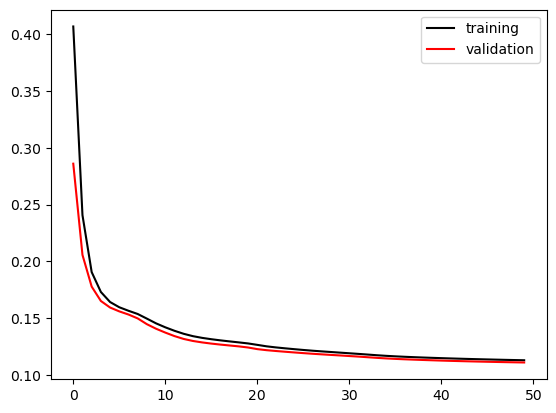

In [17]:
# visualize training and validation curves
plt.plot(history.history["mean_squared_error"], c='k', label='training')
plt.plot(history.history["val_mean_squared_error"], c='r', label='validation')
plt.legend()
plt.show()

In [18]:
# evaluation mode
data_pred = model.predict(data_test_scaled)

43479/43479 ━━━━━━━━━━━━━━━━━━━━ 18s 407us/step


In [19]:
# check prediction shape matches test data shape
data_pred.shape

(1391313, 5)

In [20]:
data_test_scaled.shape

(1391313, 5)

In [21]:
data_pred_inv = scaler.inverse_transform(data_pred)

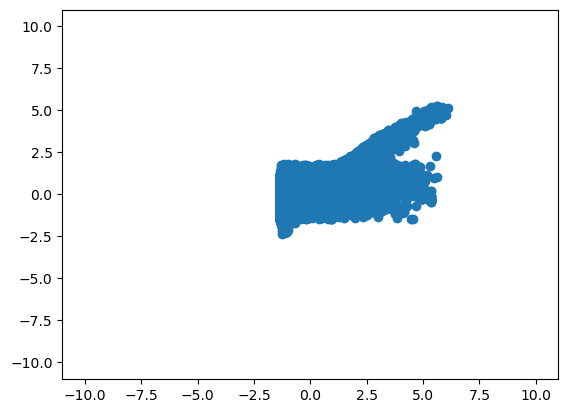

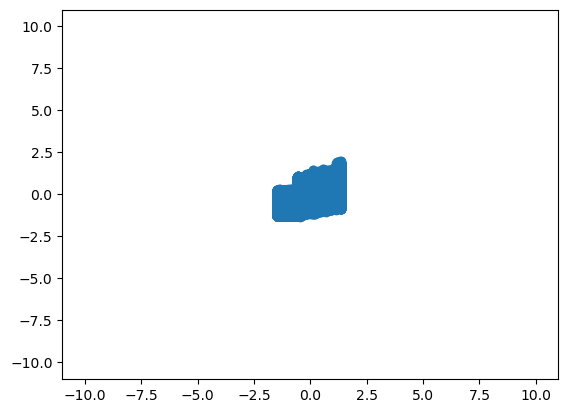

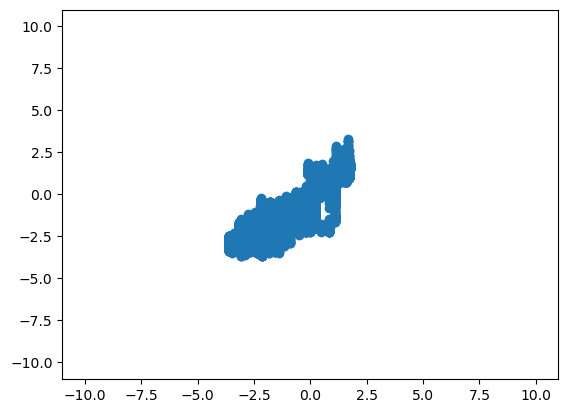

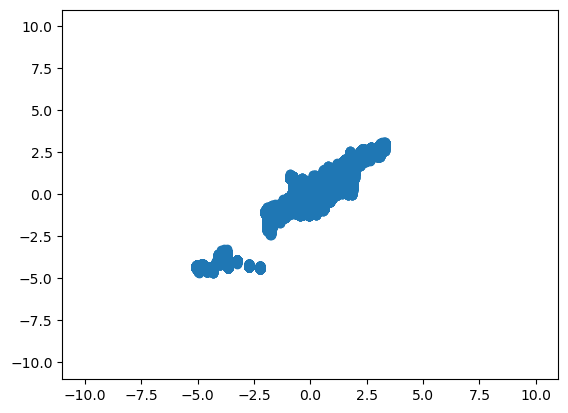

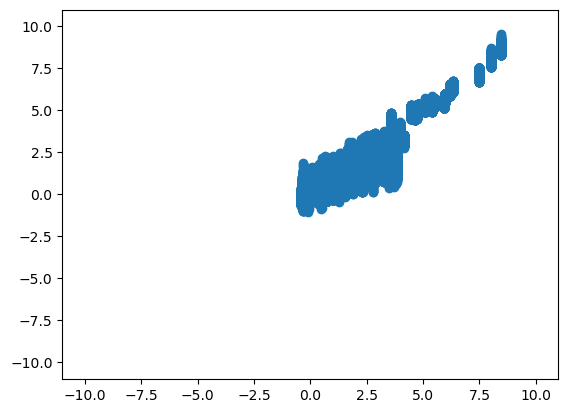

In [22]:
# visualize obs (x-axis) to nn predictions (y-axis)
for i in range(data_test_scaled.shape[1]):
    plt.scatter(data_test_scaled[:,i], data_pred[:,i])
    a = 11
    plt.xlim([-a,a])
    plt.ylim([-a,a])
    plt.show()

In [23]:
np.sqrt(1/len(data_test[:,0]) * np.sum((data_test[:,0] - data_pred_inv[:,0])**2))

0.33629193627241716

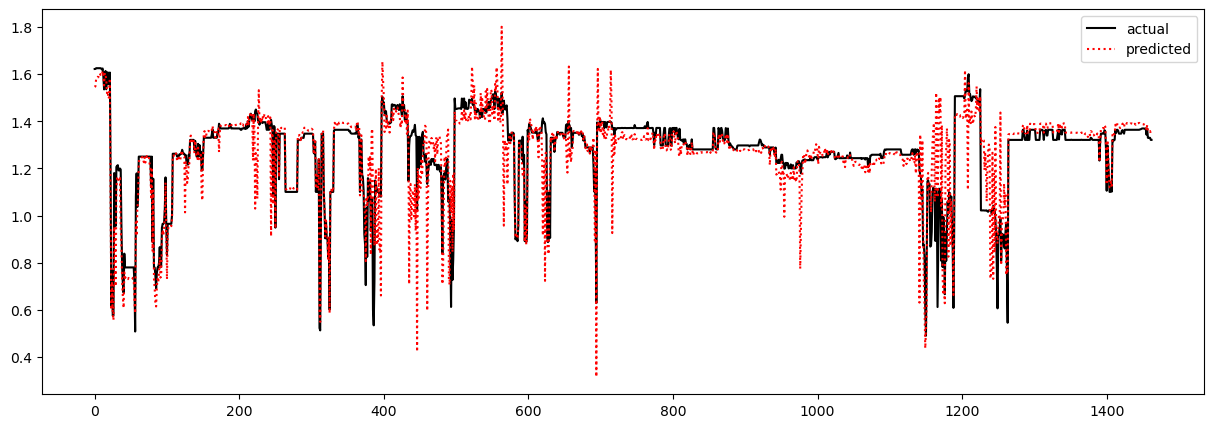

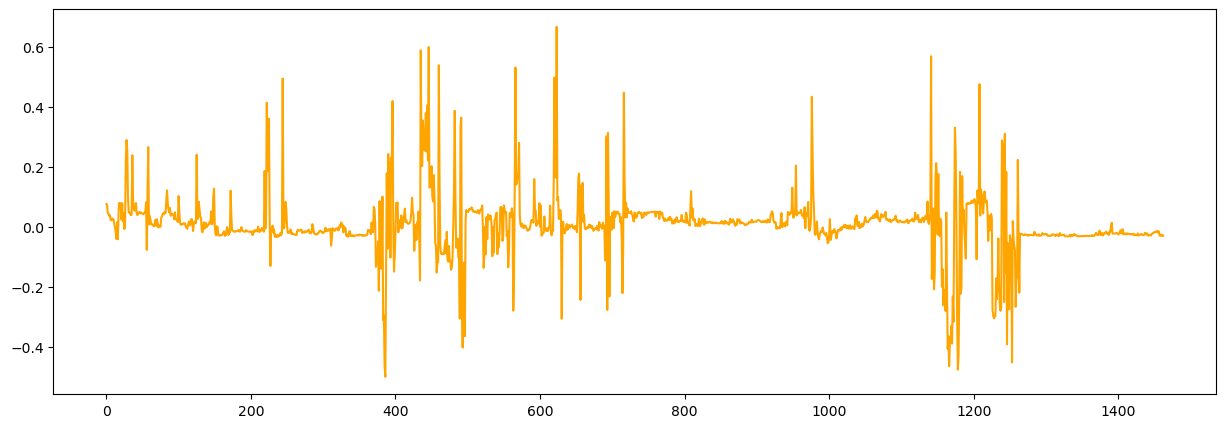

In [24]:
plt.subplots(figsize=(15,5))
plt.plot(data_test.reshape(-1,1463,5).T[0].mean(axis=1), c='k', label='actual')
plt.plot(data_pred_inv.reshape(-1,1463,5).T[0].mean(axis=1), c='r', label='predicted', linestyle=':')
plt.legend()
plt.show()

plt.subplots(figsize=(15,5))
plt.plot(data_test.reshape(-1,1463,5).T[0].mean(axis=1) - data_pred_inv.reshape(-1,1463,5).T[0].mean(axis=1), c='orange', label='difference')
plt.show()

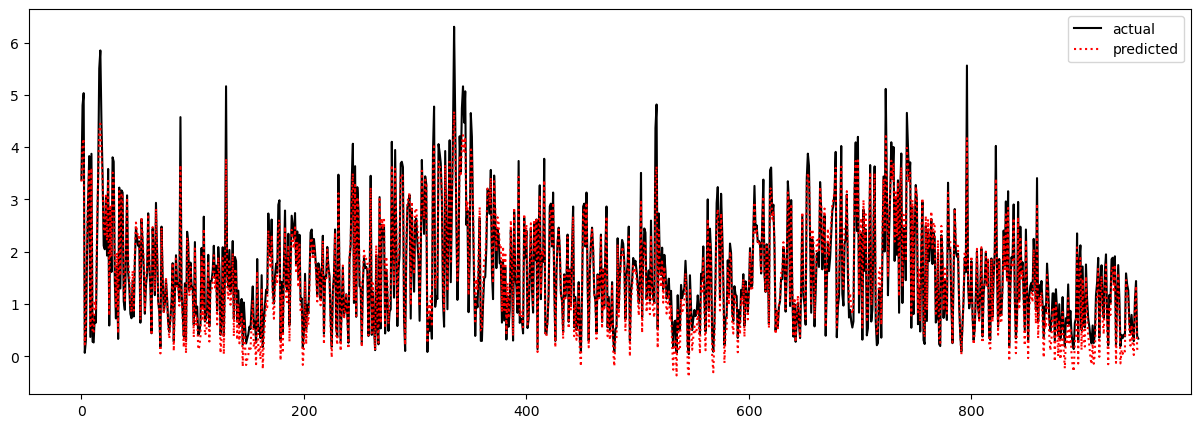

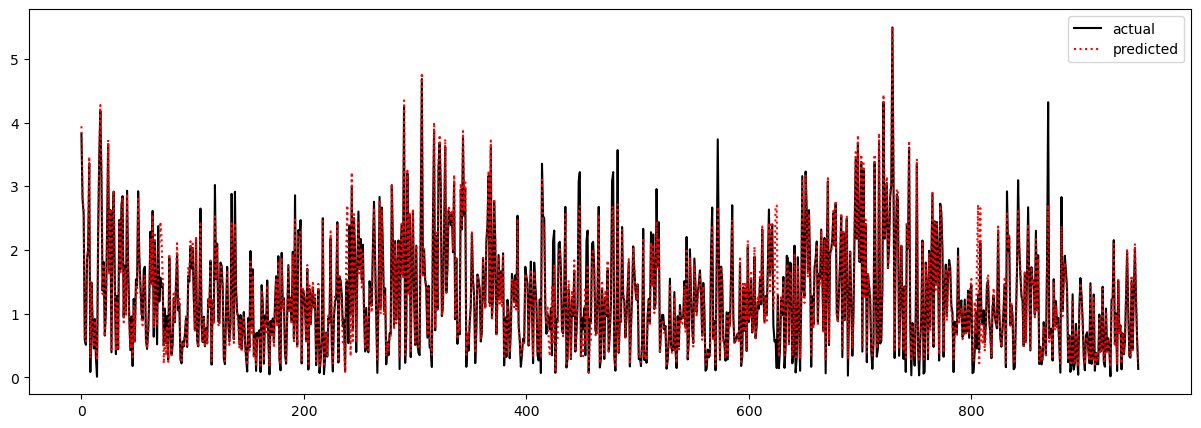

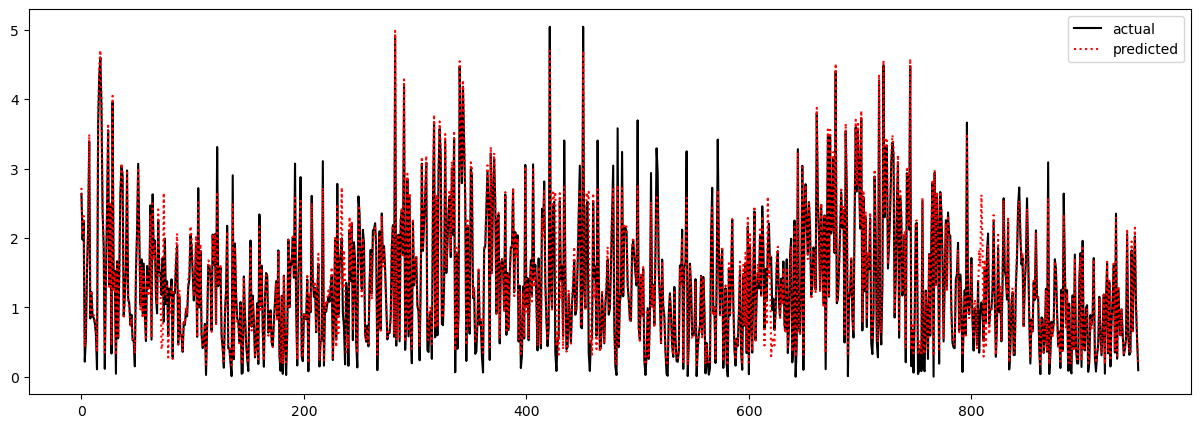

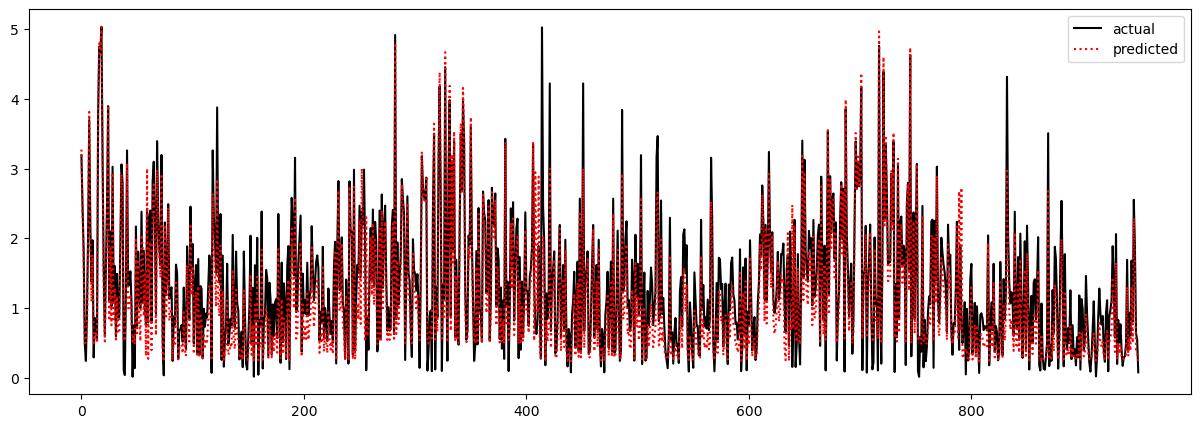

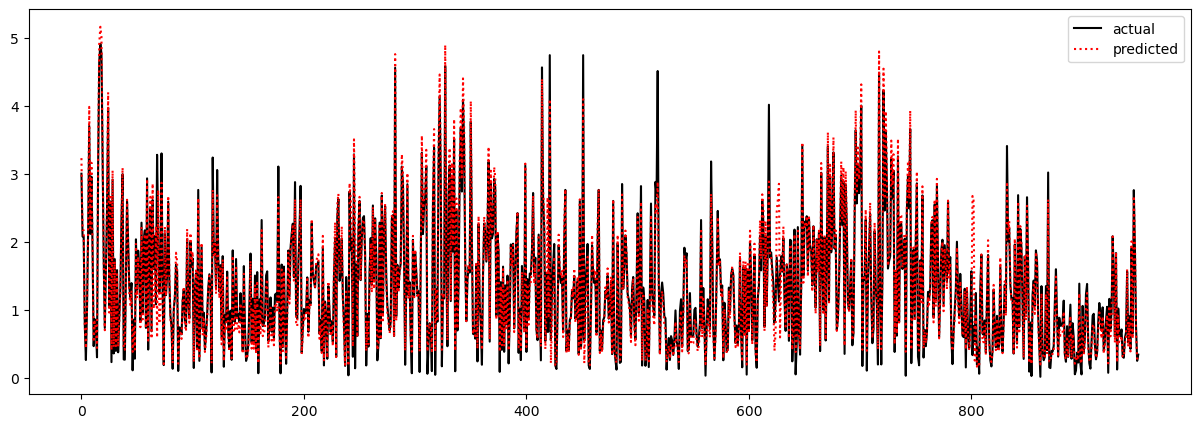

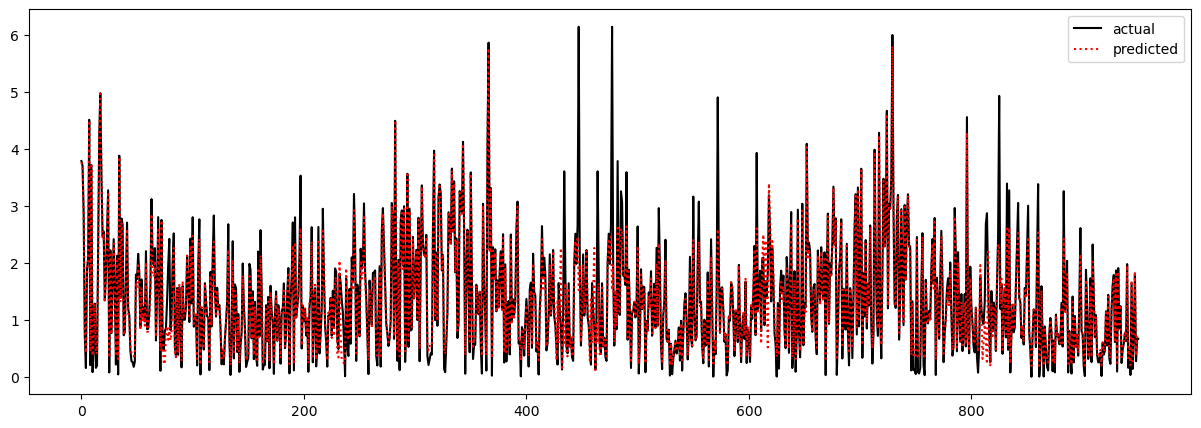

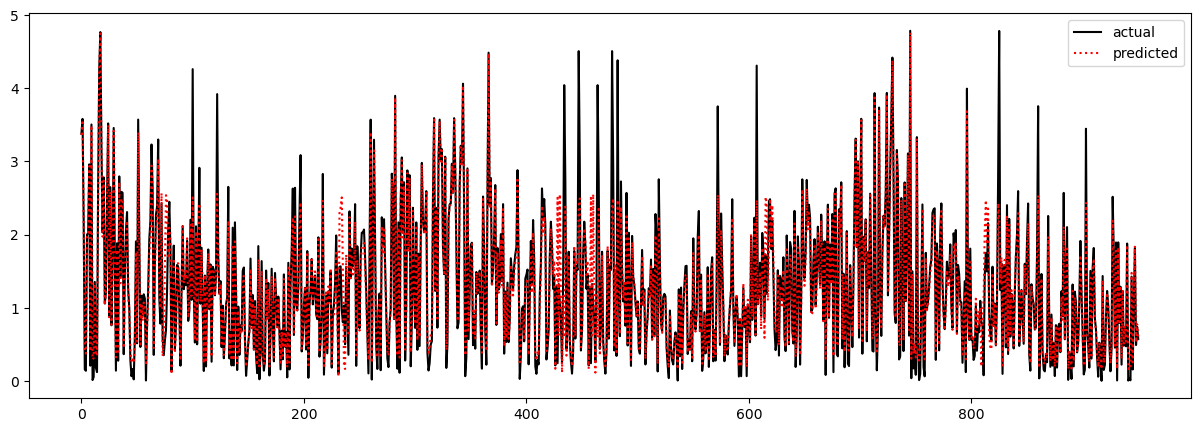

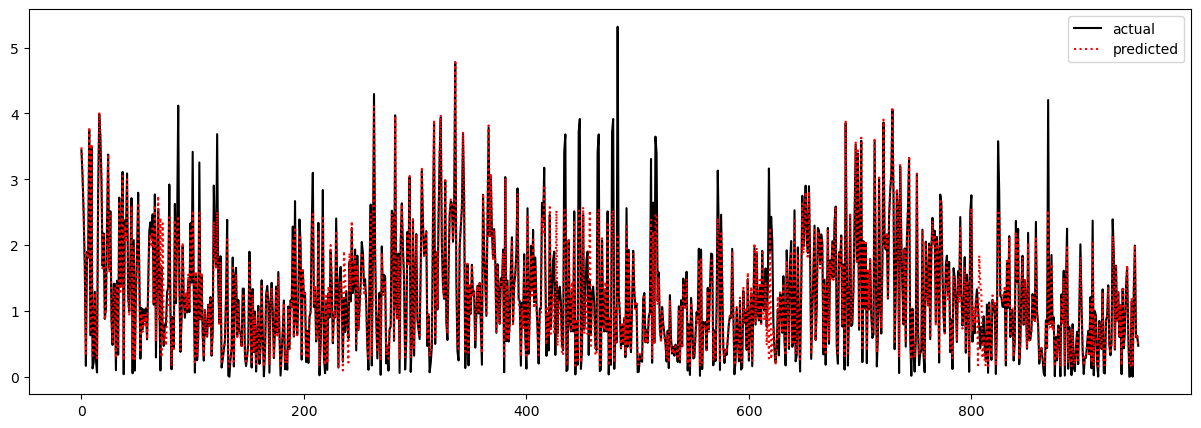

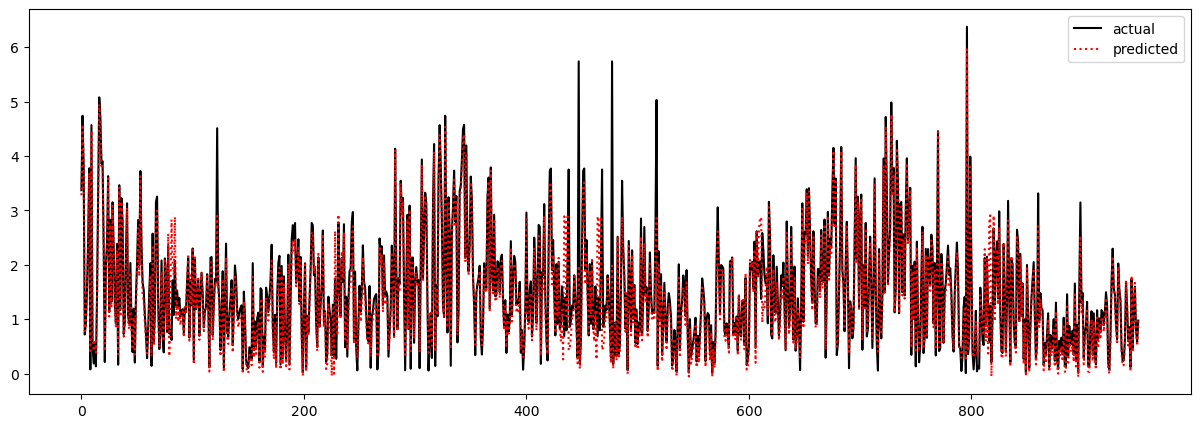

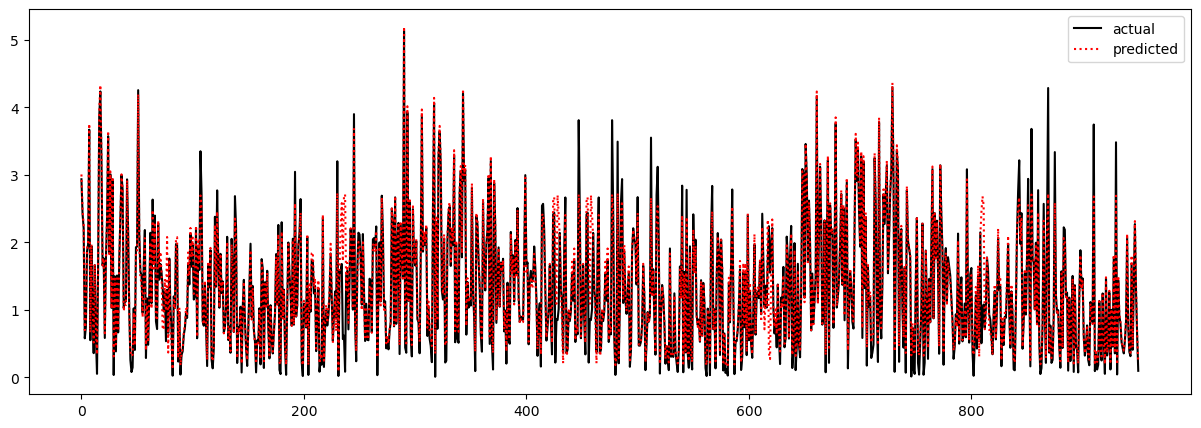

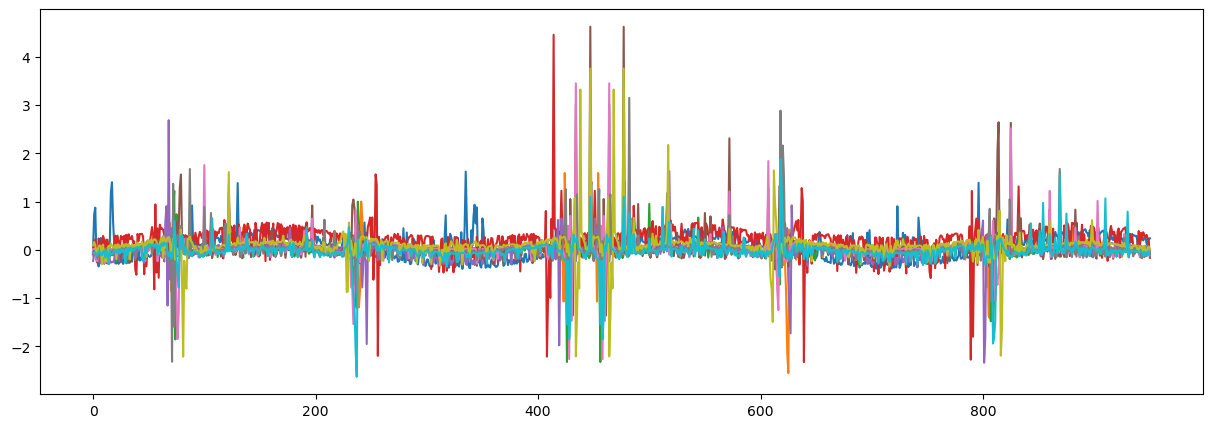

In [25]:
for i in range(0,1463, 150):
    plt.subplots(figsize=(15,5))
    plt.plot(data_test.reshape(-1,1463,5).T[0][i], c='k', label='actual')
    plt.plot(data_pred_inv.reshape(-1,1463,5).T[0][i], c='r', label='predicted', linestyle=':')
    plt.legend()
    plt.show()

plt.subplots(figsize=(15,5))
for i in range(0,1463, 150):
    plt.plot(data_test.reshape(-1,1463,5).T[0][i] - data_pred_inv.reshape(-1,1463,5).T[0][i], label='difference')
plt.show()

In [26]:
# we define the input layer to the ANN and the output of the bottleneck layer
bottleneck = tf.keras.Model(
    inputs=model.layers[0].input,
    outputs=model.layers[1].output
    )

In [27]:
# input test data into the bottleneck function
bottleneck_output = np.array(bottleneck(data_test_scaled))

In [28]:
bottleneck_output.shape

(1391313, 2)

In [29]:
bottleneck_output.shape

(1391313, 2)

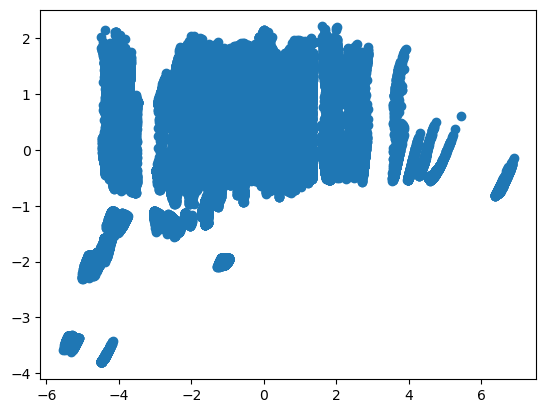

In [30]:
# we can visualize what these two nodes in the bottleneck output
plt.scatter(bottleneck_output[:,0],bottleneck_output[:,1])
plt.show()

# VAE

In [31]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [32]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [33]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(5,), name='encoder_input')

x = layers.Dense(16, activation="tanh", name='encoder_hidden')(encoder_inputs)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)

z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling(name='sample')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_hidden      │ (None, 16)        │         96 │ encoder_input[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ encoder_hidden[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ encoder_hidden[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sample (Sampling)   │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 164 (656.00 B)

 Trainable params: 164 (656.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
latent_inputs = keras.Input(shape=(latent_dim,), name='decoder_input')

x = layers.Dense(16, activation="tanh", name='decoder_hidden')(latent_inputs)

decoder_outputs = layers.Dense(5, activation="linear", name='decoder_output')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_hidden (Dense)          │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133 (532.00 B)

 Trainable params: 133 (532.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
class VAE(keras.Model):

    def __init__(self, encoder, decoder, **kwargs):

        super().__init__(**kwargs)

        self.encoder = encoder
        self.decoder = decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )

        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        # Encode the inputs
        z_mean, z_log_var, z = self.encoder(inputs)

        # Decode the latent representation
        reconstructed = self.decoder(z)

        return reconstructed

    def closs(self, data):
        z_mean, z_log_var, z = self.encoder(data)

        reconstruction = self.decoder(z)

        reconstruction_loss = ops.mean(
            ops.sum(
                keras.losses.mean_squared_error(data, reconstruction),
            )
        )

        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))

        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return total_loss
    
    def train_step(self, data):

        with tf.GradientTape() as tape:
            total_loss = self.closs(data)
            
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):

        with tf.GradientTape() as tape:
            total_loss = self.closs(data)
            
        grads = tape.gradient(total_loss, self.trainable_weights)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [36]:
vae = VAE(encoder, decoder)

In [37]:
vae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    #loss=vae.closs
    )

In [38]:
history = vae.fit(
    x=data_train_scaled,
    batch_size=1463,
    epochs=30,
    validation_split=0.1,
    shuffle=False
    )

Epoch 1/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - kl_loss: 0.9584 - loss: 1406.5231 - reconstruction_loss: 1405.5646 - val_kl_loss: 2.2922 - val_loss: 999.0945 - val_reconstruction_loss: 996.8021
Epoch 2/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - kl_loss: 2.6279 - loss: 954.2546 - reconstruction_loss: 951.6274 - val_kl_loss: 4.3469 - val_loss: 795.1332 - val_reconstruction_loss: 790.7863
Epoch 3/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - kl_loss: 4.4829 - loss: 795.6711 - reconstruction_loss: 791.1883 - val_kl_loss: 5.7396 - val_loss: 709.6884 - val_reconstruction_loss: 703.9486
Epoch 4/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - kl_loss: 5.7438 - loss: 716.4091 - reconstruction_loss: 710.6654 - val_kl_loss: 6.6031 - val_loss: 648.4925 - val_reconstruction_loss: 641.8894
Epoch 5/30
1998/1998 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - kl_loss: 6.5278 - loss: 656.9218 - reconstruction_loss: 650.3939 - val_kl_loss: 6.9970 - val_loss: 604.9438 - val_reconstruction_loss: 597.946

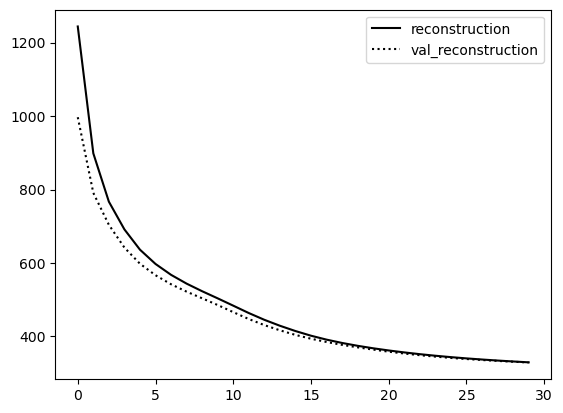

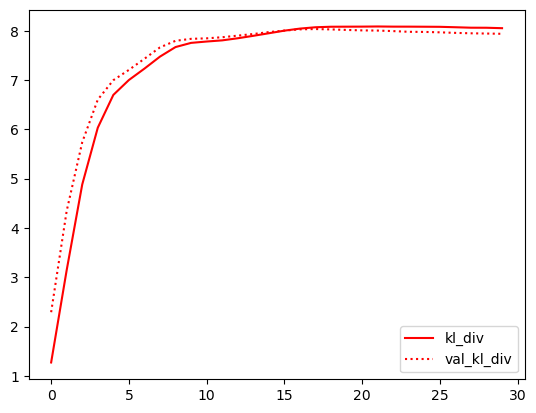

In [39]:
plt.plot(history.history["reconstruction_loss"], c='k', label='reconstruction')
plt.plot(history.history["val_reconstruction_loss"], c='k', linestyle=':', label='val_reconstruction')
plt.legend()
plt.show()

plt.plot(history.history["kl_loss"], c='r', label='kl_div')
plt.plot(history.history["val_kl_loss"], c='r', linestyle=':', label='val_kl_div')
plt.legend()
plt.show()

In [40]:
np.sqrt(1/len(data_test) * np.sum((data_test.reshape(-1,1463,5).T[0] - scaler.inverse_transform(np.array(vae.call(data_test_scaled))).reshape(-1,1463,5).T[0])**2))

0.625528871435261

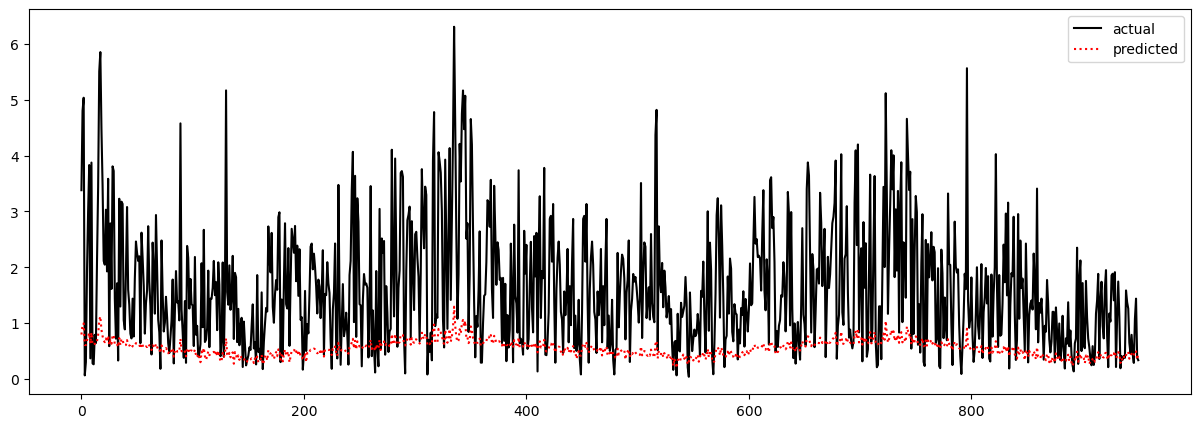

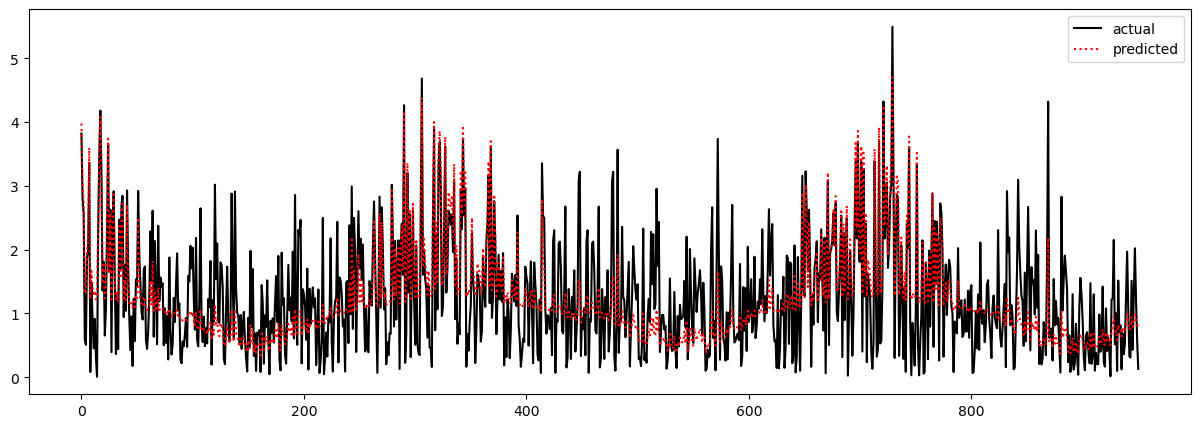

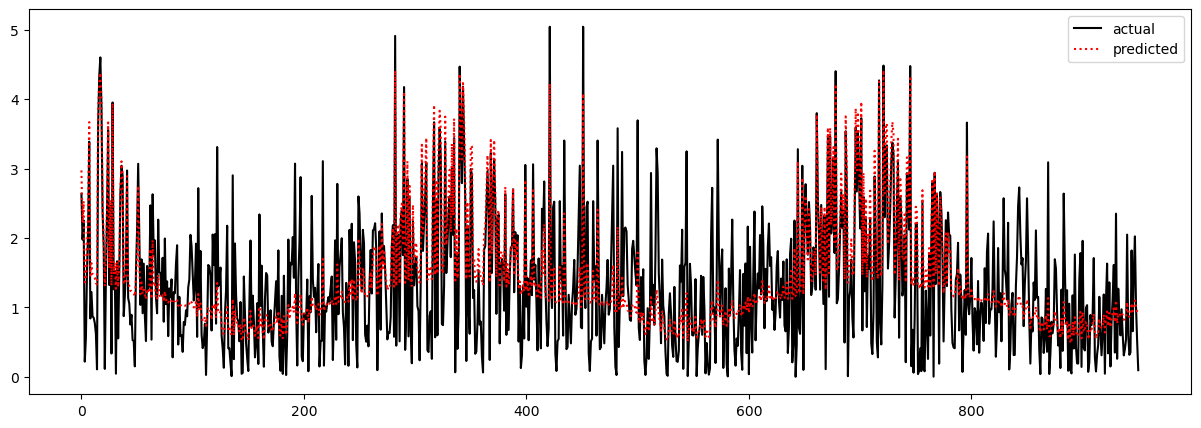

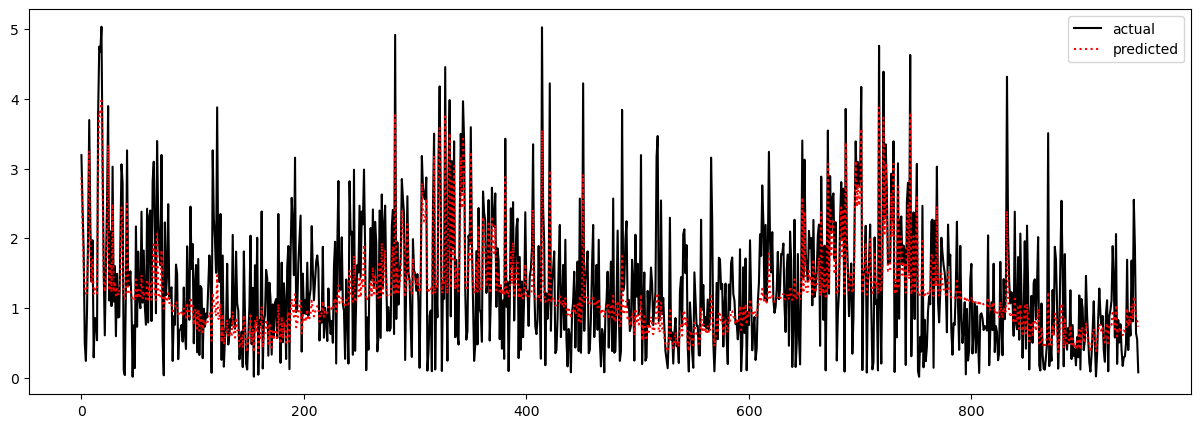

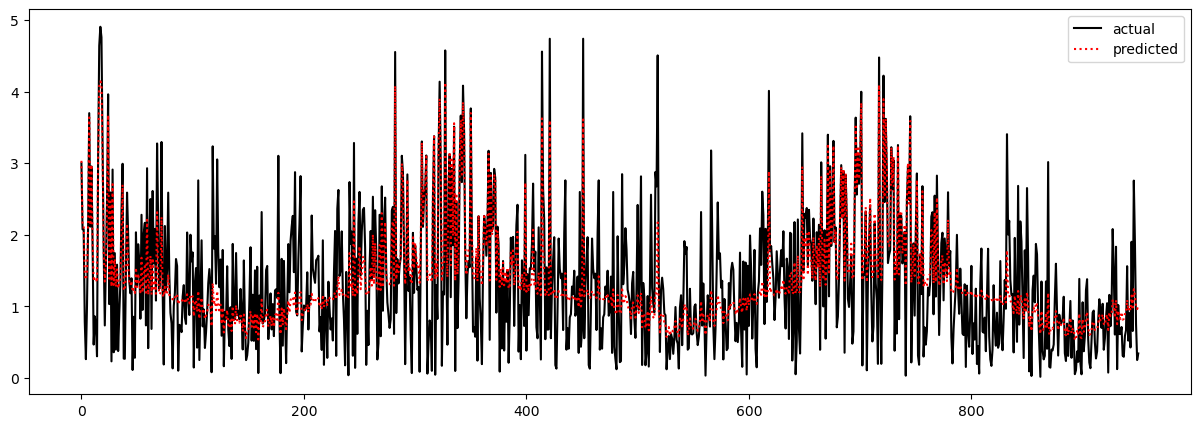

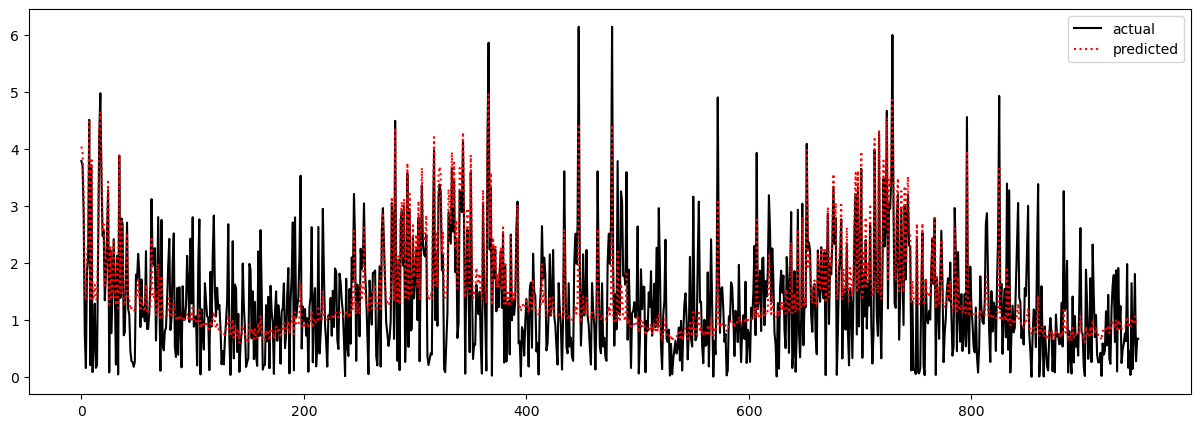

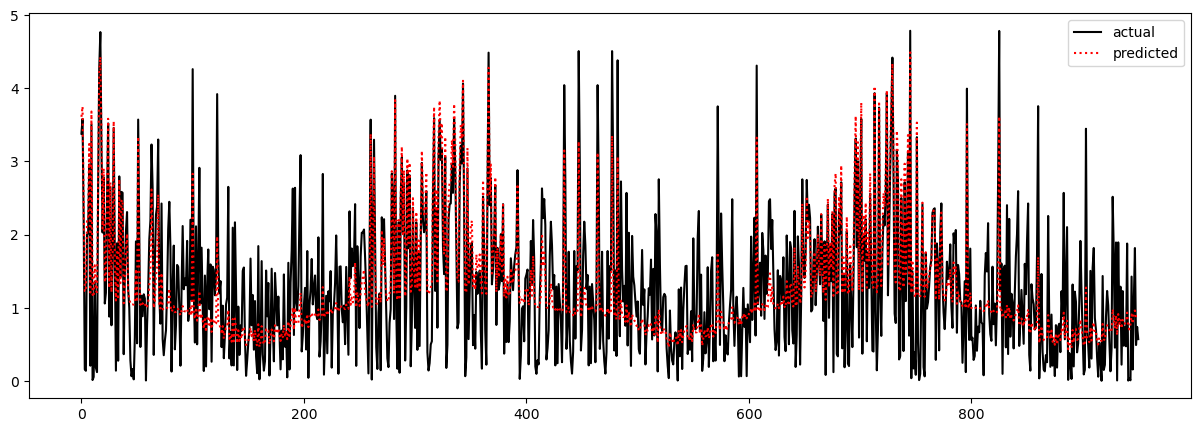

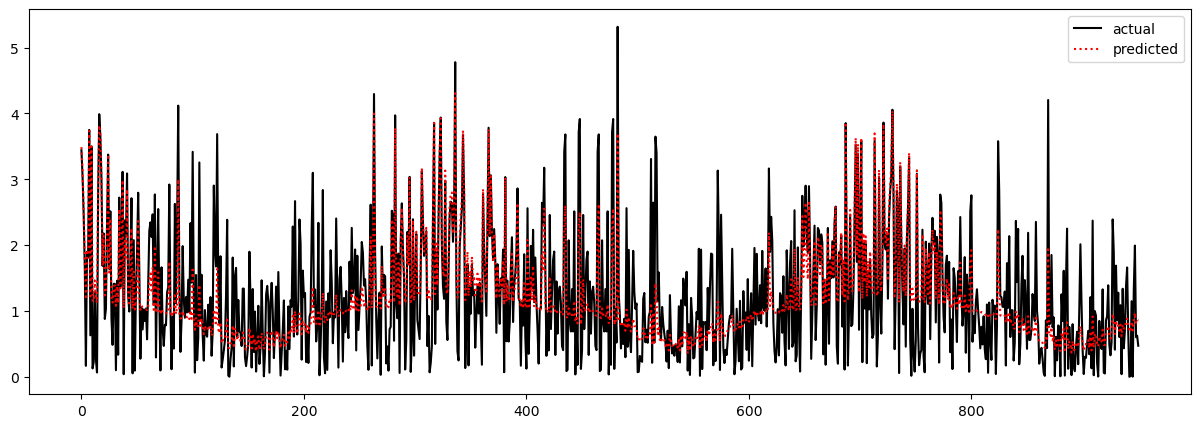

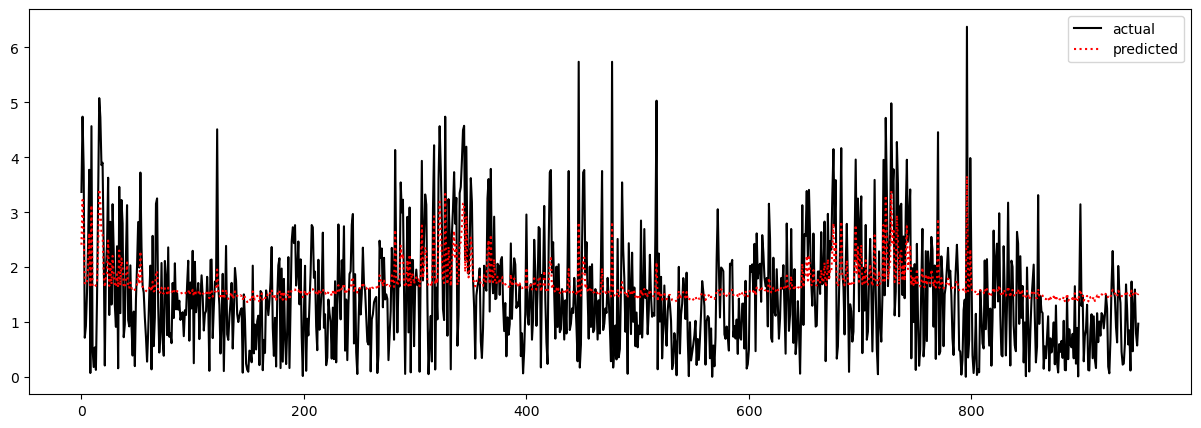

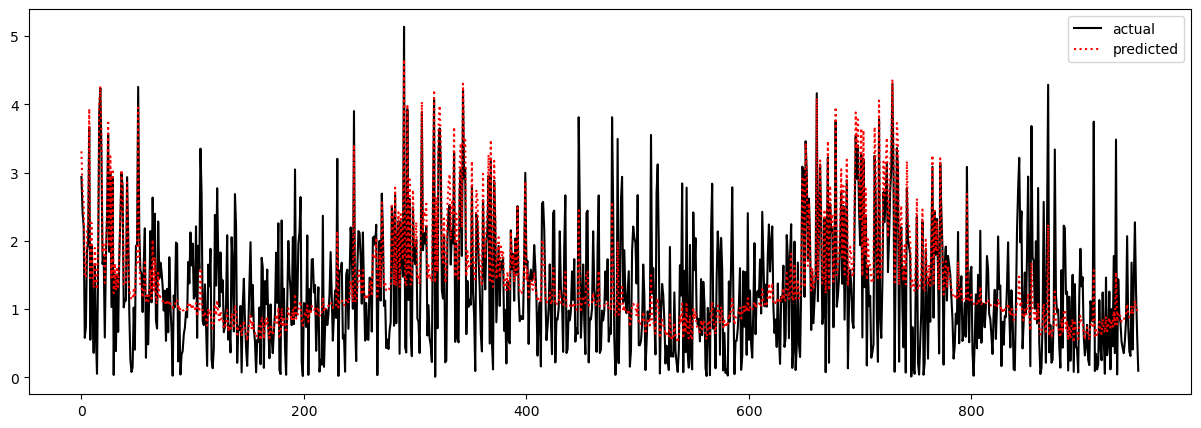

In [140]:
for i in range(0,1463, 150):
    plt.subplots(figsize=(15,5))
    plt.plot(data_test.reshape(-1,1463,5).T[0][i], c='k', label='actual')
    plt.plot(scaler.inverse_transform(np.array(vae.call(data_test_scaled))).reshape(-1,1463,5).T[0][i], c='r', label='predicted', linestyle=':')
    plt.legend()
    plt.show()

In [55]:
bottleneck = tf.keras.Model(
    inputs=vae.layers[0].input,
    outputs=vae.layers[0].output
    )

In [78]:
latent_space_mu = np.array(bottleneck(data_train_scaled)[0])
latent_space_logvar = np.array(bottleneck(data_train_scaled)[1])
latent_space_samples = np.array(bottleneck(data_train_scaled)[2])

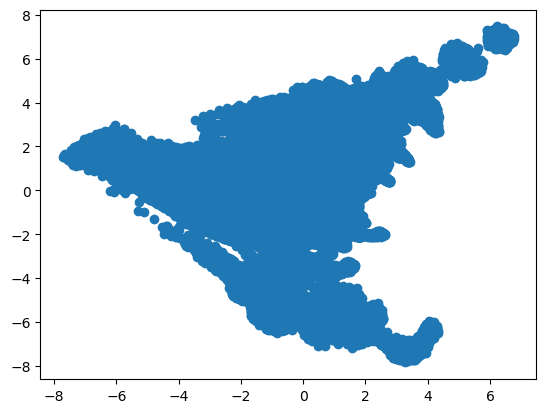

In [63]:
plt.scatter(latent_space_samples[:,0], latent_space_samples[:,1])
plt.show()

In [119]:
latent_space_mu.mean(axis=0)

array([-0.3547867 ,  0.12938054], dtype=float32)

In [118]:
latent_space_logvar.mean(axis=0)

array([-6.40035 , -7.693556], dtype=float32)

In [150]:
np.exp(0.5*latent_space_logvar.mean(axis=0))*50

array([2.0377536, 1.0674206], dtype=float32)

In [117]:
latent_space_samples.mean(axis=0)

array([-0.35480565,  0.12934129], dtype=float32)

In [148]:
latent_space_samples.std(axis=0)

array([1.4976631, 1.2514427], dtype=float32)

In [147]:
np.log(latent_space_samples.var(axis=0))

array([0.80781204, 0.4485941 ], dtype=float32)

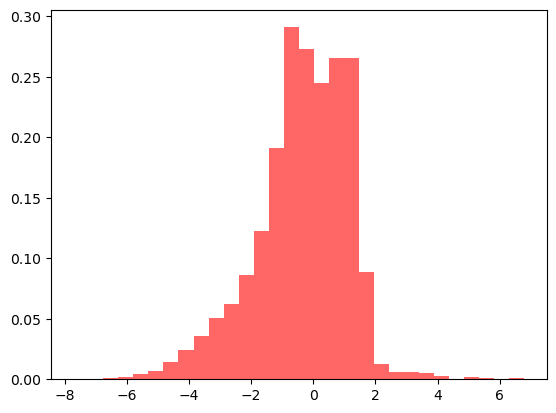

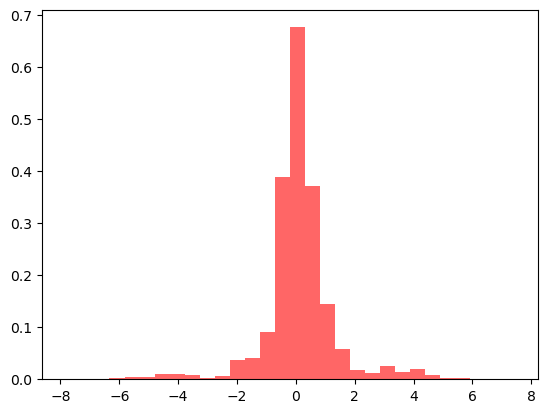

In [129]:
plt.hist(latent_space_samples[:, 0], bins=30, density=True, alpha=0.6, color='r')
plt.show()

plt.hist(latent_space_samples[:, 1], bins=30, density=True, alpha=0.6, color='r')
plt.show()

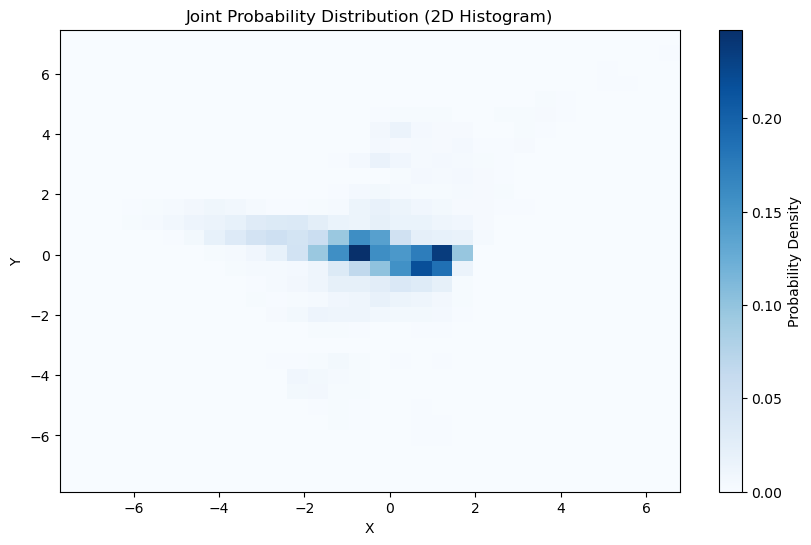

In [128]:
# Using a 2D histogram
plt.figure(figsize=(10, 6))
plt.hist2d(latent_space_samples[:, 0], latent_space_samples[:, 1], bins=30, density=True, cmap='Blues')
plt.colorbar(label='Probability Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Joint Probability Distribution (2D Histogram)')
plt.show()

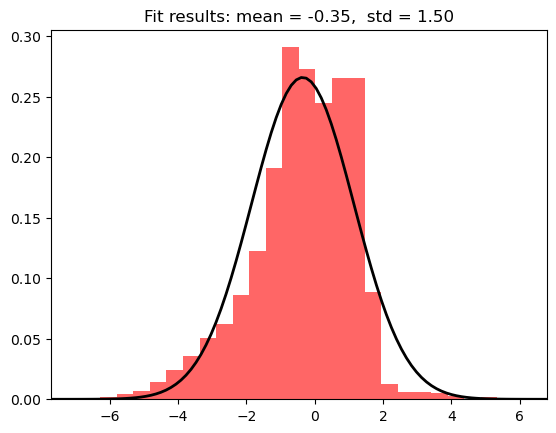

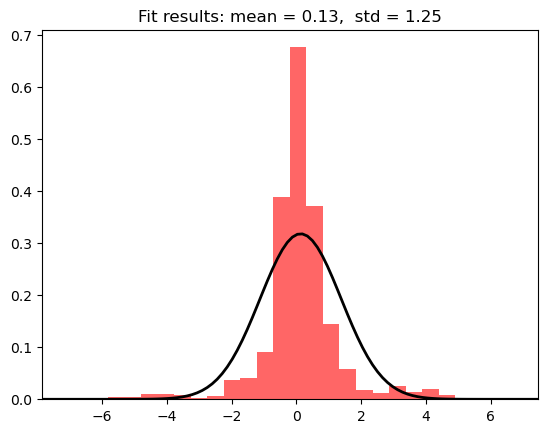

In [133]:
# Parameters for the normal distribution
mean = latent_space_samples[:, 0].mean()      # Mean of the distribution
std_dev = latent_space_samples[:, 0].std()   # Standard deviation of the distribution
sample_size = 1000  # Number of samples to generate

# Plot the probability density function (PDF)
xmin, xmax = latent_space_samples[:, 0].min(), latent_space_samples[:, 0].max()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean) / std_dev) ** 2) / (std_dev * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mean = %.2f,  std = %.2f" % (mean, std_dev)
plt.title(title)
plt.xlim([xmin, xmax])

plt.hist(latent_space_samples[:, 0], bins=30, density=True, alpha=0.6, color='r')
plt.show()

# Parameters for the normal distribution
mean = latent_space_samples[:, 1].mean()      # Mean of the distribution
std_dev = latent_space_samples[:, 1].std()   # Standard deviation of the distribution
sample_size = 1000  # Number of samples to generate

# Plot the probability density function (PDF)
xmin, xmax = latent_space_samples[:, 1].min(), latent_space_samples[:, 1].max()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean) / std_dev) ** 2) / (std_dev * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mean = %.2f,  std = %.2f" % (mean, std_dev)
plt.title(title)
plt.xlim([xmin, xmax])

plt.hist(latent_space_samples[:, 1], bins=30, density=True, alpha=0.6, color='r')
plt.show()

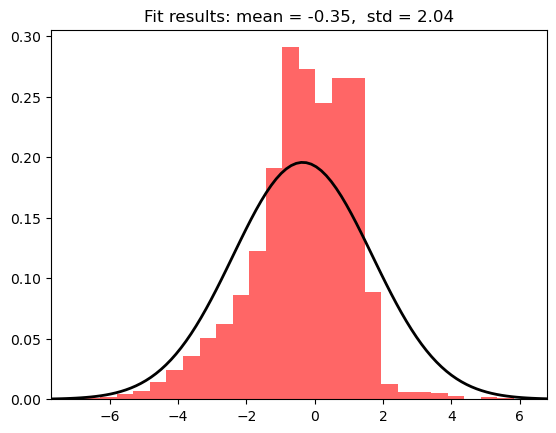

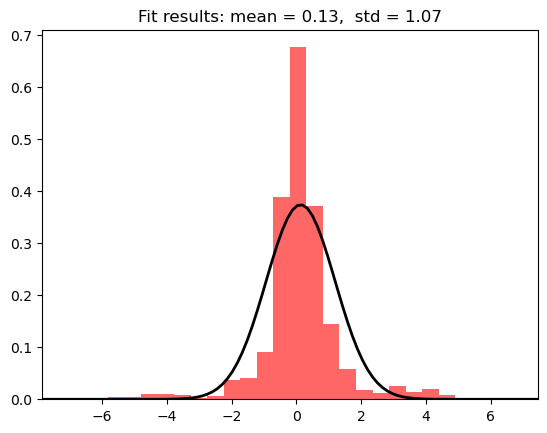

In [151]:
# Parameters for the normal distribution
mean = latent_space_mu.mean(axis=0)[0]     # Mean of the distribution
std_dev = np.exp(0.5*latent_space_logvar.mean(axis=0))[0]*50   # Standard deviation of the distribution

# Plot the probability density function (PDF)
xmin, xmax = latent_space_samples[:, 0].min(), latent_space_samples[:, 0].max()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean) / std_dev) ** 2) / (std_dev * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mean = %.2f,  std = %.2f" % (mean, std_dev)
plt.title(title)
plt.xlim([xmin, xmax])

plt.hist(latent_space_samples[:, 0], bins=30, density=True, alpha=0.6, color='r')
plt.show()

# Parameters for the normal distribution
mean = latent_space_mu.mean(axis=0)[1]      # Mean of the distribution
std_dev = np.exp(0.5*latent_space_logvar.mean(axis=0))[1]*50   # Standard deviation of the distribution

# Plot the probability density function (PDF)
xmin, xmax = latent_space_samples[:, 1].min(), latent_space_samples[:, 1].max()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean) / std_dev) ** 2) / (std_dev * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mean = %.2f,  std = %.2f" % (mean, std_dev)
plt.title(title)
plt.xlim([xmin, xmax])

plt.hist(latent_space_samples[:, 1], bins=30, density=True, alpha=0.6, color='r')
plt.show()

In [121]:
scaler.inverse_transform(np.array(vae.decoder(latent_space_samples[np.newaxis,0,:])))

array([[ 5.7966608e-01, -2.3028131e-01,  3.9554966e+01, -7.9203606e+01,
         3.0535379e+08]], dtype=float32)

In [134]:
scaler.inverse_transform(np.array(vae.decoder(np.array([-10, 2])[np.newaxis,:])))

array([[ 5.3937879e+00,  9.2889363e-01,  3.9386620e+01, -7.6614227e+01,
         1.2343232e+07]], dtype=float32)

In [135]:
scaler.inverse_transform(np.array(vae.decoder(np.array([2, -2])[np.newaxis,:])))

array([[ 2.4934433e-01, -7.5062984e-01,  3.9570076e+01, -7.7193024e+01,
         1.1364003e+08]], dtype=float32)